In [1]:
%pwd

'/users/5/dever120/FMPlug/notebooks'

In [2]:
%cd ..

/users/5/dever120/FMPlug


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
from flow_matching.solver.ode_solver import ODESolver
from skimage.metrics import peak_signal_noise_ratio
from torch.optim import AdamW
from torch.optim.lr_scheduler import ConstantLR
from torchvision import datasets, transforms
from torchvision.transforms.v2 import Compose, ToDtype, ToImage

from fmplug.engine.scaling import NativeScaler
from fmplug.engine.trainer import train_one_epoch
from fmplug.engine.utils import get_time_discretization
from fmplug.models.cfg_scaled import CFGScaledModel
from fmplug.models.utils import instantiate_model
from fmplug.utils.image_utils import mask_generator
from fmplug.utils.measurements import get_noise, get_operator

/tmp/ipykernel_2841501/1183321174.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Setup
device = torch.device("cuda:0")

# Load The Dataset

In [5]:
dataset = "cifar10"

# Load the MNIST dataset
transform = transforms.Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
])


if dataset == "celeba":
    train_dataset = datasets.CelebA(
        '/home/jusun/dever120/datasets/celeba',
        split="train",
        download=True,
        transform=transform
    )
    test_dataset = datasets.CelebA(
        '/home/jusun/dever120/datasets/celeba',
        split="test",
        transform=transform
    )

elif dataset == "cifar10":
    train_dataset = datasets.CIFAR10(
        '../data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.CIFAR10(
        '../data',
        train=False,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [6]:
train_data = next(iter(train_loader))

In [7]:
images = train_data[0]
images.shape

torch.Size([64, 3, 32, 32])

In [8]:
# Extract a single image to view
image = (
    images[0, :, :, :]
    .squeeze()
    .numpy()
    .transpose(2, 1, 0)
    .transpose(1, 0, 2)
)

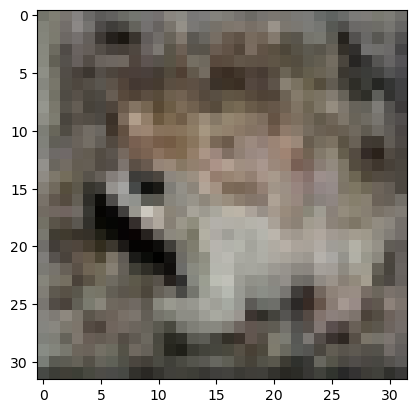

In [9]:
plt.imshow(image)

# Train the Flow Matching Model

In [10]:
# Initialize the model
model = instantiate_model(
    architechture=dataset,
    is_discrete=False,
    use_ema=True,
)

model_without_ddp = model.to(device)

In [11]:
# Number of epochs
epochs = 5

# Initialize the optimizer
optimizer = torch.optim.AdamW(
    model_without_ddp.parameters(),
    lr=1e-4,
    eps=1e-8,
)

# Initalize the learning rate scheduler
lr_schedule = torch.optim.lr_scheduler.ConstantLR(
    optimizer, total_iters=(len(train_loader) * epochs), factor=1.0
)

# Initialize the scaler used for mixed precision
loss_scaler = NativeScaler()

/users/5/dever120/FMPlug/fmplug/engine/scaling.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


In [12]:
for epoch in tqdm.tqdm(range(0, epochs)):
    train_stats = train_one_epoch(
        model=model,
        data_loader=train_loader,
        optimizer=optimizer,
        lr_schedule=lr_schedule,
        device=device,
        epoch=epoch,
        loss_scaler=loss_scaler,
    )
    
    log_stats = {
        **{f"train_{k}": v for k, v in train_stats.items()},
        "epoch": epoch,
    }

  0%|          | 0/5 [00:00<?, ?it/s]/users/5/dever120/FMPlug/fmplug/engine/trainer.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True, dtype=torch.float32):
 20%|██        | 1/5 [02:41<10:46, 161.65s/it]

Number of loss violations: 0


 40%|████      | 2/5 [05:23<08:06, 162.04s/it]

Number of loss violations: 0


 60%|██████    | 3/5 [08:06<05:24, 162.32s/it]

Number of loss violations: 0


 80%|████████  | 4/5 [10:49<02:42, 162.37s/it]

Number of loss violations: 0


100%|██████████| 5/5 [13:31<00:00, 162.34s/it]

Number of loss violations: 0


In [13]:
# Produce an image
cfg_scaled_model = CFGScaledModel(model=model)
cfg_scaled_model.train(False)

solver = ODESolver(velocity_model=cfg_scaled_model)
ode_opts = {"step_size": 0.01, "nfe": 5}

# Generate an Image

In [14]:
samples, labels = next(iter(test_loader))

In [15]:
samples_shape = samples.shape
sample_channels = samples_shape[1]
sample_img_width = samples_shape[2]
sample_img_height = samples_shape[3]

print(
    samples_shape,
    sample_channels,
    sample_img_width,
    sample_img_height
)

torch.Size([64, 3, 32, 32]) 3 32 32


In [16]:
edm_schedule = True

# Continuous sampling
x_0 = torch.randn((1, sample_channels, sample_img_width, sample_img_height), dtype=torch.float32, device=device)

if edm_schedule:
    time_grid = get_time_discretization(nfes=ode_opts["nfe"])
    
else:
    time_grid = torch.tensor([0.0, 1.0], device=device)

synthetic_samples = solver.sample(
    time_grid=time_grid,
    x_init=x_0,
    method="heun2",
    return_intermediates=False,
    atol=ode_opts["atol"] if "atol" in ode_opts else 1e-5,
    rtol=ode_opts["rtol"] if "atol" in ode_opts else 1e-5,
    step_size=ode_opts["step_size"]
    if "step_size" in ode_opts
    else None,
    label={},  # No labels for our task
    cfg_scale=0.0,  # 0.0 is unconditional and 1.0 is conditional on the label
)

# Scaling to [0, 1] from [-1, 1]
synthetic_samples = torch.clamp(
    synthetic_samples * 0.5 + 0.5, min=0.0, max=1.0
)
synthetic_samples = torch.floor(synthetic_samples * 255)
synthetic_samples = synthetic_samples.to(torch.float32) / 255.0

/users/5/dever120/FMPlug/fmplug/models/cfg_scaled.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  torch.cuda.amp.autocast(enabled=True, dtype=torch.float32),


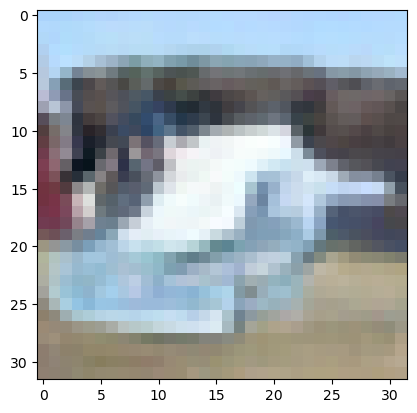

In [17]:
synthetic_img = (
    synthetic_samples
    .detach()
    .cpu()
    .squeeze()
    .numpy()
)

synthetic_img = (
    synthetic_img
    .transpose(2, 1, 0)
    .transpose(1, 0, 2)
)

plt.imshow(synthetic_img)

# Inverse Problem

In [18]:
config = {
    'measurement': {
        'operator': {'name': 'inpainting'},
        'mask_opt': {'mask_type': 'random', 'mask_prob_range': (0.4, 0.4), 'image_size': 32},
        'noise': {'name': 'gaussian', 'sigma': 0.01}
    }
}

measure_config = config["measurement"]

In [19]:
# Test samples
test_samples, test_labels = next(iter(test_loader))

# Create the reference image
ref_img = test_samples[0, :, :, :].squeeze()
ref_numpy = ref_img

print(ref_img.shape, ref_numpy.shape)

ref_img = ref_img * 2.0 - 1.0
ref_img = torch.tensor(ref_img)
ref_img = (
    ref_img
    .unsqueeze(0)
    .to(device)
)
print(ref_img.min(), ref_img.max(), ref_img.device)

# Initalize operator
operator = get_operator(device=device, **measure_config['operator'])
noiser = get_noise(**measure_config['noise'])

# For this case we will add a mask
# and then noise
mask_gen = mask_generator(
    **measure_config['mask_opt']
)
mask = mask_gen(ref_img)
mask = mask[:, 0, :, :].unsqueeze(dim=0)

# Forward measurement model (Ax + n)
y = operator.forward(ref_img, mask=mask)
y_n = noiser(y)

torch.Size([3, 32, 32]) torch.Size([3, 32, 32])
tensor(-0.8980, device='cuda:0') tensor(1., device='cuda:0') cuda:0


/tmp/ipykernel_2841501/2485779471.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_img = torch.tensor(ref_img)


In [20]:
y_n.shape

torch.Size([1, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06048107..1.0043092].


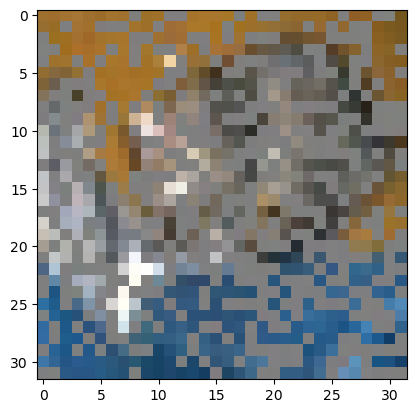

In [21]:
# Let's look at y_n
# map back to [0, 1]
noised_img = (y_n + 1) / 2
noised_img = (
    noised_img
    .detach()
    .cpu()
    .squeeze()
    .numpy()
    .transpose(1, 2, 0)
)

plt.imshow(noised_img)

In [22]:
image_size = y_n.shape[2]

In [23]:
# Learning rate
lr = 1e-2

# FMPlug
z = torch.randn(
    (1, 3, image_size, image_size),
    device=device,
    dtype=torch.float32,
    requires_grad=True
)
print(z.shape)
criterion = torch.nn.MSELoss().to(device)
params_group1 = {'params': z, 'lr': lr}

optimizer = torch.optim.AdamW([params_group1])

torch.Size([1, 3, 32, 32])


In [24]:
epochs = 500 # SR, inpainting: 5,000, nonlinear deblurring: 10,000

psnrs = []
losses = []
best_images = []

if edm_schedule:
    # small number of evaluations
    time_grid = get_time_discretization(nfes=5)
    
else:
    time_grid = torch.tensor([0.0, 1.0], device=device)

for iterator in tqdm.tqdm(range(epochs)):
    model.eval()
    optimizer.zero_grad()

    # Iterate over the path
    x_t = solver.sample(
        time_grid=time_grid,
        x_init=z,
        method="heun2",
        return_intermediates=False,
        enable_grad=True,
        atol=ode_opts["atol"] if "atol" in ode_opts else 1e-5,
        rtol=ode_opts["rtol"] if "atol" in ode_opts else 1e-5,
        step_size=ode_opts["step_size"]
        if "step_size" in ode_opts
        else None,
        label={},
        cfg_scale=0.0,  # 0.0 is unconditional and 1.0 is conditional on the label
    )

    # Make sure values are between -1 and 1
    output = torch.clamp(x_t, -1, 1)
    if measure_config['operator']['name'] == 'inpainting':
        # In the inverse problem we want to estimate the noise operator
        loss = criterion(operator.forward(output, mask=mask), y_n)
        
    else:
        loss = criterion(operator.forward(output), y_n)
        
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # Evaluate
    with torch.no_grad():
        output_numpy = output.detach().cpu().squeeze().numpy()
        output_numpy = (output_numpy + 1) / 2
        output_numpy = np.transpose(output_numpy, (1, 2, 0))  # Keep out for now lets evaluate
        
        # calculate psnr
        tmp_psnr = peak_signal_noise_ratio(
            ref_numpy.numpy().transpose(1, 2, 0),
            output_numpy
        )
        psnrs.append(tmp_psnr)
        
        if len(psnrs) == 1 or (len(psnrs) > 1 and tmp_psnr > np.max(psnrs[:-1])):
            best_img = output_numpy
            best_images.append(best_img)

100%|██████████| 500/500 [20:17<00:00,  2.44s/it]


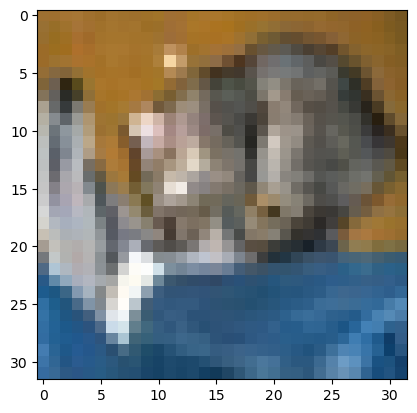

In [25]:
display_ref_img = (
    ref_numpy
    .detach()
    .cpu()
    .squeeze()
    .numpy()
    .transpose(1, 2, 0)
)

plt.imshow(display_ref_img)

In [26]:
best_img = best_images[-1]
best_img = (
    best_img
)
best_img.shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06048107..1.0043092].


Text(0.5, 1.0, 'Reconstructed Image (FM)')

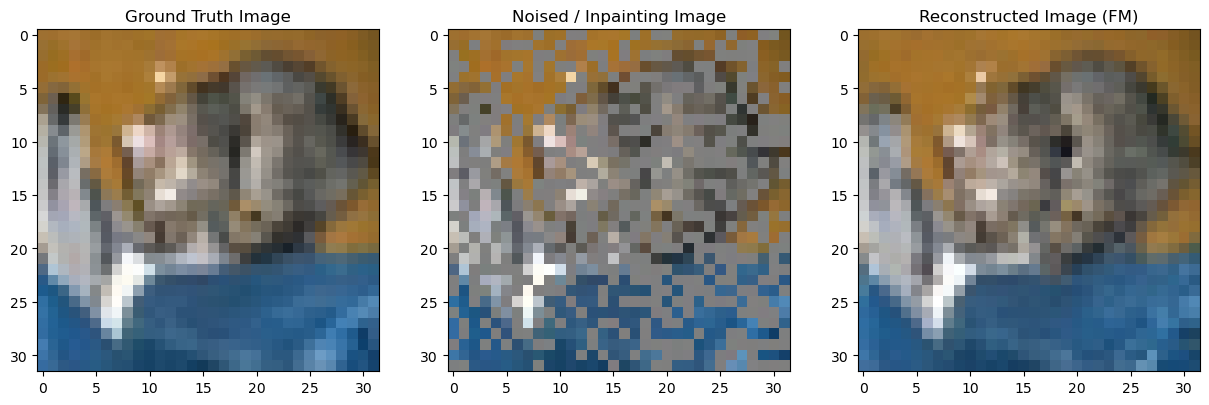

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(display_ref_img)
ax1.set_title("Ground Truth Image")

ax2.imshow(noised_img)
ax2.set_title("Noised / Inpainting Image")

ax3.imshow(best_img)
ax3.set_title("Reconstructed Image (FM)")

<Axes: >

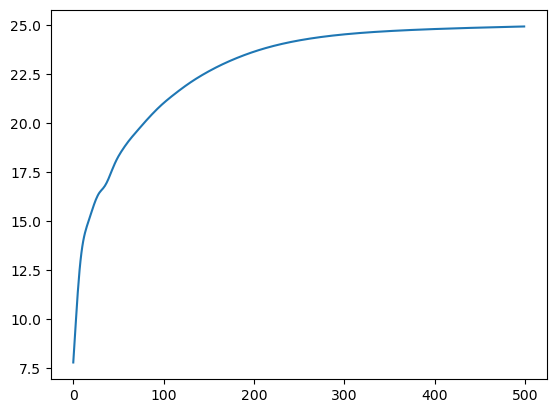

In [28]:
psnr_trajectory = pd.Series(psnrs)
psnr_trajectory.plot()